## Model training

While we try to keep training time somewhat reasonable, some models may take a while, especially in cross-validation. Where possible we have used the `n_jobs` parameter to parallelize the training. After tuning the hyperparameters models are stored in the models folder as pickled files though, so they can also be used without retraining.

For runtime reasons we for example only trained one non-linear SVM model and tried to speed up RF parameter search by parallelizing and using warm starts.

In [222]:
# change number of workers when running on a different machine
WORKERS = 8

In [40]:
from sklearn.model_selection import train_test_split  # For splitting the data
from sklearn.linear_model import LogisticRegression  # For training the model
from sklearn.metrics import accuracy_score, classification_report  # For evaluating the model
import joblib
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import numpy as np

In [2]:
data_path = os.path.join("data", "small_data_eda.zip")
# Load data
data = pd.read_csv(data_path)
data.head()

,product,narrative,narrative_len,narrative_prep,narrative_prep_len,text_lemma,word_count,char_count,sentence_count,sentiment
0,credit_card,used third party company book vacation package...,64,party company book vacation package notified c...,53,party company book vacation package notify com...,64,485,1,-0.138095
1,credit_card,company u bank reliacard issue account locked ...,66,company u bank reliacard issue account locked ...,58,company u bank reliacard issue account locked ...,66,421,1,-0.083333
2,credit_card,victim identity fraud personal financial infor...,91,victim identity fraud personal financial infor...,83,victim identity fraud personal financial infor...,91,696,1,-0.002679
3,credit_card,browsing online site invited apply credit card...,70,browsing online site invited apply credit card...,64,browse online site invite apply credit card si...,70,496,1,-0.243056
4,credit_card,made payment credit card balance resulting cre...,20,payment credit card balance resulting credit b...,18,payment credit card balance result credit bala...,20,143,1,0.000000


In [3]:
# Ensure that both 'narrative_prep' and 'product' have no missing values
#data_filtered = data.dropna(subset=['narrative_prep', 'product'])
# Encode the target variable (Product Categories)
le = LabelEncoder()
y = le.fit_transform(data['product'])  

In [4]:
from sklearn.metrics import confusion_matrix

# train and evaluate a model
def train_evaluate_model(X_train, y_train, X_test, y_test, model):
    # train the model
    model.fit(X_train, y_train)

    # predict the labels
    y_pred = model.predict(X_test)

    # evaluate with report and confusion matrix
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    cm = confusion_matrix(y_test, y_pred)
    
    return report, cm


def tune_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test):
    # grid search with cv for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, refit=True, verbose=2, cv=5, n_jobs=WORKERS)
    grid_search.fit(X_train, y_train)

    print("Best hyperparameters: ", grid_search.best_params_)

    # take best model
    best_model = grid_search.best_estimator_

    # get report and confusion matrix
    report, cm = train_evaluate_model(X_train, y_train, X_test, y_test, best_model)

    return report, cm, model

# plot confusion matrix
def plot_confusion_matrix(cm, target_names=le.classes_):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


**TF-IDF Preprocessing**

In [5]:
os.environ["TOKENIZERS_PARALLELISM"] = "false" # allow to do cv in parallel without warnings
# load tfidf embeddings
tfidf_df = pd.read_pickle(os.path.join("data", "tfidf_embeddings.pkl"))
tfidf_df.drop('product', axis=1, inplace=True) # we already have the target variable in y
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, y, test_size=0.2, random_state=42)

**Word2Vec Preprocessing**

In [6]:
# load embeddings
w2v_df = pd.read_pickle(os.path.join("data", "word2vec_embeddings.pkl"))
# only consider embeddings for X
X_w2v = pd.DataFrame(w2v_df['narrative_tokenized_vector'].tolist(), index=w2v_df.index)
# split into training and testing sets
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

#### 1) TF-IDF - Logistic regression

In [7]:
# train logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_report, cm = train_evaluate_model(X_train, y_train, X_test, y_test, lr_model)
print("Logistic Regression Report with TF-IDF Features:")
print(lr_report)

Logistic Regression Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.77      0.77      0.77      2637
   credit_reporting       0.75      0.75      0.75      2631
    debt_collection       0.78      0.75      0.77      2694
mortgages_and_loans       0.84      0.83      0.84      2710
     retail_banking       0.83      0.86      0.84      2763

           accuracy                           0.79     13435
          macro avg       0.79      0.79      0.79     13435
       weighted avg       0.79      0.79      0.79     13435



##### 1.1) TF-IDF - Logistic regression - Hyperparameter tuning

In [8]:
# parameter grid for logistic regression
param_grid_lr = {'C': [0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear']}
report, cm, model = tune_and_evaluate_model(lr_model, param_grid_lr, X_train, y_train, X_test, y_test)
# save the model
joblib.dump(model, os.path.join("models", "lr_tfidf_model.pkl"))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.9s
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.9s
[CV] END ................................C=0.1, solver=lbfgs; total time=   1.3s
[CV] END ................................C=0.1, solver=lbfgs; total time=   1.3s
[CV] END ................................C=0.1, solver=lbfgs; total time=   1.4s
[CV] END ............................C=0.1, solver=liblinear; total time=   1.7s
[CV] END ............................C=0.1, solver=liblinear; total time=   1.7s
[CV] END ............................C=0.1, solver=liblinear; total time=   1.8s
[CV] END ............................C=0.1, solver=liblinear; total time=   1.8s
[CV] END ............................C=0.1, solver=liblinear; total time=   1.8s
[CV] END ..................................C=1, solver=lbfgs; total time=   1.8s
[CV] END ..................................C=1, s

['models/lr_tfidf_model.pkl']

Logistic Regression Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.77      0.77      0.77      2637
   credit_reporting       0.75      0.75      0.75      2631
    debt_collection       0.78      0.75      0.77      2694
mortgages_and_loans       0.84      0.83      0.84      2710
     retail_banking       0.83      0.86      0.84      2763

           accuracy                           0.79     13435
          macro avg       0.79      0.79      0.79     13435
       weighted avg       0.79      0.79      0.79     13435



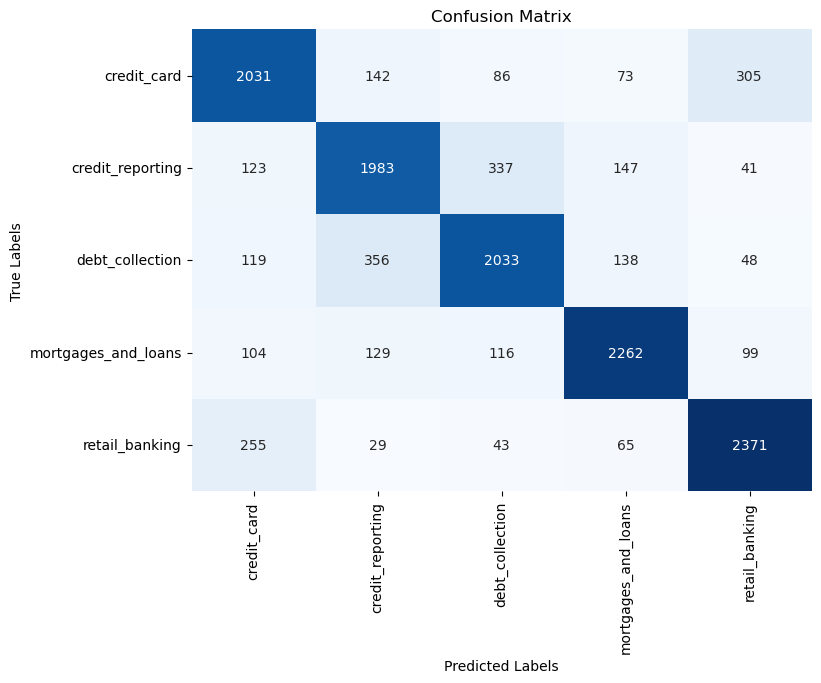

In [9]:
print("Logistic Regression Report with TF-IDF Features:")
print(report)
plot_confusion_matrix(cm)

#### 2) TF-IDF - Random Forest Classifier

In [10]:
# RF classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=10, n_jobs=WORKERS)
rf_report, cm = train_evaluate_model(X_train, y_train, X_test, y_test, rf_model)
print("Random Forest Report with TF-IDF Features:")
print(rf_report)

Random Forest Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.79      0.79      0.79      2637
   credit_reporting       0.80      0.79      0.80      2631
    debt_collection       0.82      0.81      0.82      2694
mortgages_and_loans       0.87      0.85      0.86      2710
     retail_banking       0.83      0.86      0.85      2763

           accuracy                           0.82     13435
          macro avg       0.82      0.82      0.82     13435
       weighted avg       0.82      0.82      0.82     13435



##### 2.1) TF-IDF - Random Forest - Hyperparameter tuning

In [11]:
# param grid for hyperparameters
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

report, cm, model_rf = tune_and_evaluate_model(RandomForestClassifier(n_jobs=WORKERS), param_grid_rf, X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   8.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   8.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   9.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   9.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   9.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  17.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  17.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  17.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  17.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  17.2s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   8.8s
[CV] END max_depth=10, min_samples_split=5, n_e

/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=  40.6s
[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=  40.6s
[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=  40.6s
[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=  40.8s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=  17.8s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=  17.2s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=  17.4s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=  17.6s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=  19.1s
[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=  13.6s
[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=  12.2s
[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=  12.5s
[CV] END max_depth=20, mi

In [12]:
# save the model
joblib.dump(model, os.path.join("models", "rf_tfidf_model.pkl"))

['models/rf_tfidf_model.pkl']

Random Forest Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.79      0.79      0.79      2637
   credit_reporting       0.80      0.79      0.80      2631
    debt_collection       0.81      0.80      0.81      2694
mortgages_and_loans       0.87      0.86      0.86      2710
     retail_banking       0.83      0.86      0.84      2763

           accuracy                           0.82     13435
          macro avg       0.82      0.82      0.82     13435
       weighted avg       0.82      0.82      0.82     13435



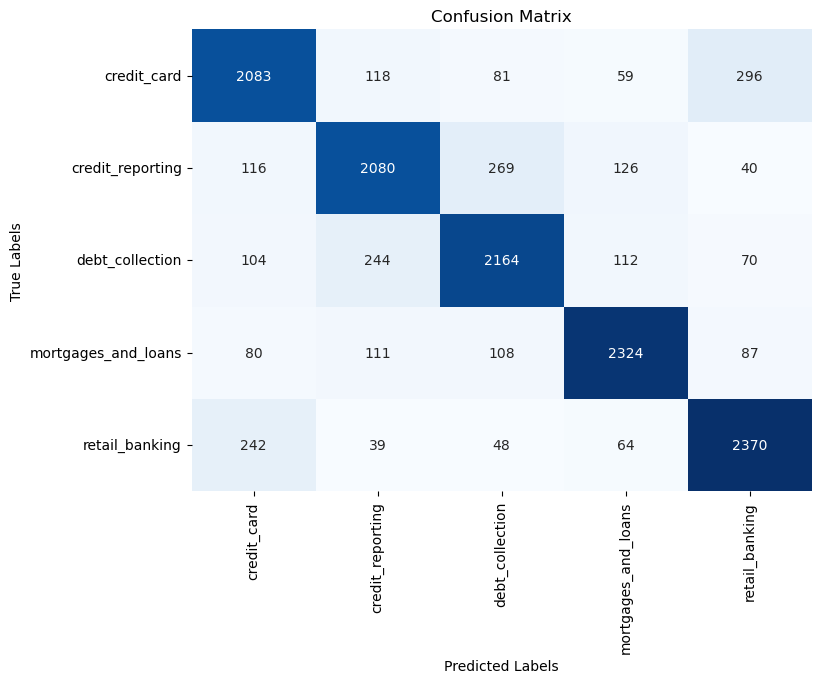

In [13]:
print("Random Forest Report with TF-IDF Features:")
print(report)
plot_confusion_matrix(cm)

#### 3) TF-IDF - XGBoost Classifier

In [14]:
# XGBoost classifier
xgb_model = XGBClassifier(eval_metric='mlogloss')
xgb_report, cm = train_evaluate_model(X_train, y_train, X_test, y_test, xgb_model)
print("XGBoost Report with TF-IDF Features:")
print(xgb_report)

XGBoost Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.80      0.80      0.80      2637
   credit_reporting       0.79      0.79      0.79      2631
    debt_collection       0.80      0.81      0.81      2694
mortgages_and_loans       0.87      0.85      0.86      2710
     retail_banking       0.85      0.86      0.86      2763

           accuracy                           0.82     13435
          macro avg       0.82      0.82      0.82     13435
       weighted avg       0.82      0.82      0.82     13435



##### 3.1) TF-IDF - XGBoost - Hyperparameter tuning

In [15]:
# XGBoost Hyperparameter tuning
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}
report, cm, model = tune_and_evaluate_model(xgb_model, param_grid_xgb, X_train, y_train, X_test, y_test)
joblib.dump(model, os.path.join("models", "xgb_tfidf_model.pkl"))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......................max_depth=3, n_estimators=100; total time=   6.8s
[CV] END ......................max_depth=3, n_estimators=100; total time=   7.0s
[CV] END ......................max_depth=3, n_estimators=100; total time=   7.1s
[CV] END ......................max_depth=3, n_estimators=100; total time=   7.2s


/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ......................max_depth=3, n_estimators=100; total time=  11.1s
[CV] END ......................max_depth=3, n_estimators=200; total time=  12.4s
[CV] END ......................max_depth=3, n_estimators=200; total time=  12.8s
[CV] END ......................max_depth=3, n_estimators=200; total time=  12.8s
[CV] END ......................max_depth=3, n_estimators=200; total time=  19.3s
[CV] END ......................max_depth=3, n_estimators=200; total time=  19.3s
[CV] END ......................max_depth=4, n_estimators=100; total time=   8.8s
[CV] END ......................max_depth=4, n_estimators=100; total time=   8.9s
[CV] END ......................max_depth=4, n_estimators=100; total time=  12.0s
[CV] END ......................max_depth=3, n_estimators=300; total time=  18.3s
[CV] END ......................max_depth=3, n_estimators=300; total time=  18.5s
[CV] END ......................max_depth=3, n_estimators=300; total time=  18.8s
[CV] END ...................

['models/xgb_tfidf_model.pkl']

XGBoost Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.79      0.80      0.80      2637
   credit_reporting       0.80      0.79      0.79      2631
    debt_collection       0.80      0.82      0.81      2694
mortgages_and_loans       0.87      0.85      0.86      2710
     retail_banking       0.85      0.87      0.86      2763

           accuracy                           0.82     13435
          macro avg       0.82      0.82      0.82     13435
       weighted avg       0.82      0.82      0.82     13435



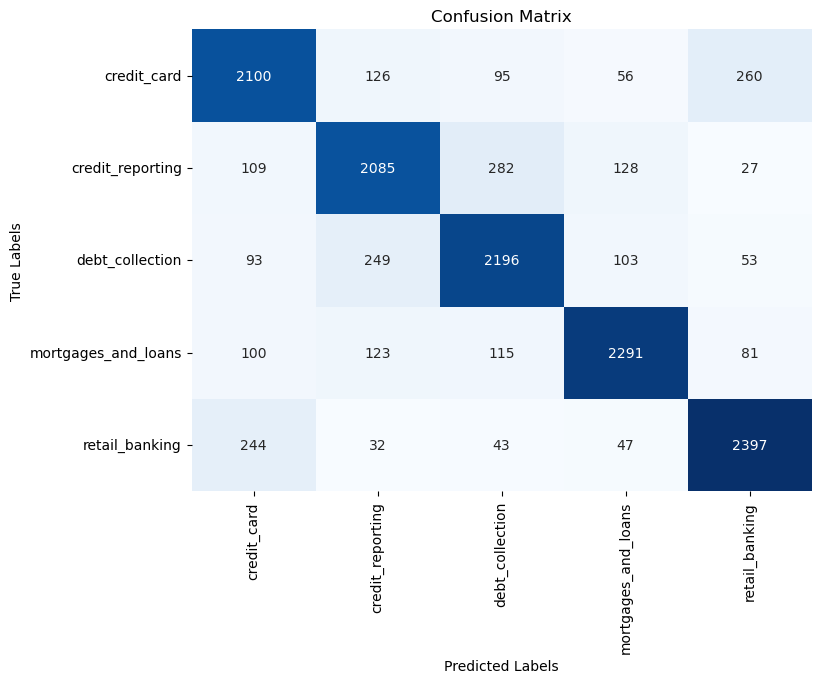

In [16]:
print("XGBoost Report with TF-IDF Features:")
print(report)
plot_confusion_matrix(cm)


#### 4) TF-IDF - Naive Bayes Classifier

In [17]:
# Naive Bayes Classifier
nb_model = MultinomialNB()
nb_report, _ = train_evaluate_model(X_train, y_train, X_test, y_test, nb_model)
print("Naive Bayes Report with TF-IDF Features:")
print(nb_report)

Naive Bayes Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.73      0.72      0.72      2637
   credit_reporting       0.72      0.75      0.74      2631
    debt_collection       0.77      0.67      0.72      2694
mortgages_and_loans       0.79      0.85      0.82      2710
     retail_banking       0.81      0.84      0.82      2763

           accuracy                           0.77     13435
          macro avg       0.76      0.76      0.76     13435
       weighted avg       0.77      0.77      0.76     13435



##### 4.1) TF-IDF - Naive Bayes - Hyperparameter tuning

In [18]:
# Naiva Bayes Hyperparameter tuning
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0]
}
report, cm, model = tune_and_evaluate_model(nb_model, param_grid_nb, X_train, y_train, X_test, y_test)  
joblib.dump(model, os.path.join("models", "nb_tfidf_model.pkl"))


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.1s
[CV] END ..........................................alpha=0.5; total time=   0.1s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ........................................

/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters:  {'alpha': 0.1}


['models/nb_tfidf_model.pkl']

Naive Bayes Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.73      0.72      0.72      2637
   credit_reporting       0.72      0.75      0.74      2631
    debt_collection       0.77      0.67      0.72      2694
mortgages_and_loans       0.79      0.85      0.82      2710
     retail_banking       0.81      0.84      0.82      2763

           accuracy                           0.77     13435
          macro avg       0.76      0.76      0.76     13435
       weighted avg       0.77      0.77      0.76     13435



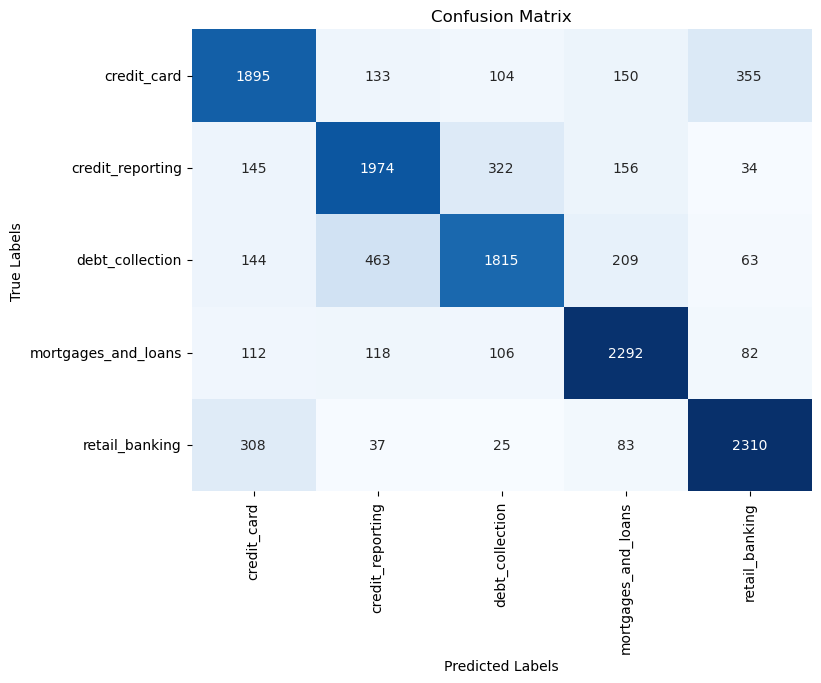

In [19]:
print("Naive Bayes Report with TF-IDF Features:")
print(report)
plot_confusion_matrix(cm)

#### 5) TF-IDF - Support Vector Machine Classifier

To speed up things, we first train a linear SVM model and then a non-linear one (without extensive hyperparameter tuning).

In [20]:
# train a linear SVM model first with LinearSVC
svm_model = LinearSVC()
svm_report, cm = train_evaluate_model(X_train, y_train, X_test, y_test, svm_model)
print("Linear SVM Report with TF-IDF Features:")
print(svm_report)

Linear SVM Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.77      0.76      0.77      2637
   credit_reporting       0.73      0.75      0.74      2631
    debt_collection       0.79      0.73      0.76      2694
mortgages_and_loans       0.84      0.84      0.84      2710
     retail_banking       0.82      0.87      0.84      2763

           accuracy                           0.79     13435
          macro avg       0.79      0.79      0.79     13435
       weighted avg       0.79      0.79      0.79     13435



In [21]:
# tune it 
param_grid_svm = {
    'C': [0.1, 1, 10, 15]
}

report, cm, model = tune_and_evaluate_model(svm_model, param_grid_svm, X_train, y_train, X_test, y_test)
joblib.dump(model, os.path.join("models", "svm_lin_tfidf_model.pkl"))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..............................................C=0.1; total time=   2.0s
[CV] END ..............................................C=0.1; total time=   2.1s
[CV] END ..............................................C=0.1; total time=   2.1s
[CV] END ..............................................C=0.1; total time=   2.3s


/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ................................................C=1; total time=   2.5s
[CV] END ................................................C=1; total time=   2.5s
[CV] END ................................................C=1; total time=   2.5s
[CV] END ................................................C=1; total time=   2.5s
[CV] END ..............................................C=0.1; total time=   2.3s
[CV] END ................................................C=1; total time=   2.6s
[CV] END ...............................................C=10; total time=   2.7s
[CV] END ...............................................C=10; total time=   2.6s
[CV] END ...............................................C=10; total time=   2.5s
[CV] END ...............................................C=10; total time=   2.6s
[CV] END ...............................................C=15; total time=   2.6s
[CV] END ...............................................C=10; total time=   2.7s
[CV] END ...................

['models/svm_lin_tfidf_model.pkl']

In [22]:
# support vector machine with rbf kernel
svm_model = SVC(max_iter=100, kernel='rbf', gamma='auto', cache_size=4096) # stop early to get faster convergence
# use linearsvc
svm_model = LinearSVC()
report, _ = train_evaluate_model(X_train, y_train, X_test, y_test, svm_model)
print("SVM Report with TF-IDF Features:")
print(report)

SVM Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.77      0.76      0.77      2637
   credit_reporting       0.73      0.75      0.74      2631
    debt_collection       0.79      0.73      0.76      2694
mortgages_and_loans       0.84      0.84      0.84      2710
     retail_banking       0.82      0.87      0.84      2763

           accuracy                           0.79     13435
          macro avg       0.79      0.79      0.79     13435
       weighted avg       0.79      0.79      0.79     13435



SVM Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.77      0.77      0.77      2637
   credit_reporting       0.73      0.78      0.75      2631
    debt_collection       0.80      0.73      0.76      2694
mortgages_and_loans       0.85      0.83      0.84      2710
     retail_banking       0.83      0.87      0.85      2763

           accuracy                           0.80     13435
          macro avg       0.80      0.79      0.79     13435
       weighted avg       0.80      0.80      0.80     13435



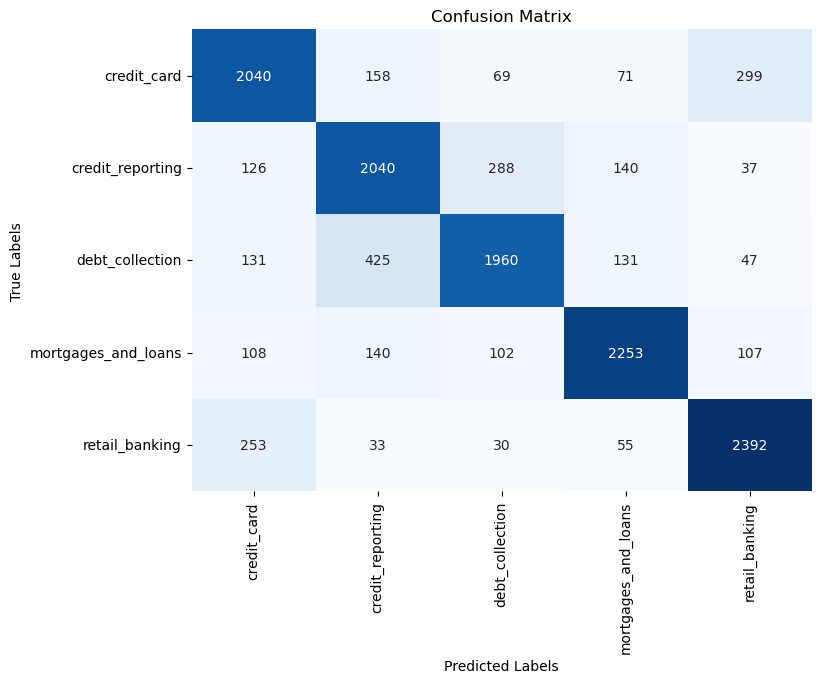

['models/svm_rbf_tfidf_model.pkl']

In [23]:
# train one non-linear SVM model with rbf kernel and higher regularization without early stopping
svm_model = SVC(kernel='rbf', gamma='auto', C=10, cache_size=4096) # set cache size depending on available memory
report, cm = train_evaluate_model(X_train, y_train, X_test, y_test, svm_model)

print("SVM Report with TF-IDF Features:")
print(report)
plot_confusion_matrix(cm)

# save the model
joblib.dump(svm_model, os.path.join("models", "svm_rbf_tfidf_model.pkl"))

#### 6) Word2Vec - Logistic regression

In [24]:
# train lr model
lr_model_w2v = LogisticRegression(max_iter=1000)
lr_report_w2v, _ = train_evaluate_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, lr_model_w2v)
print("Logistic Regression Report with Word2Vec Features:")
print(lr_report_w2v)

Logistic Regression Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.78      0.80      0.79      2637
   credit_reporting       0.79      0.77      0.78      2631
    debt_collection       0.81      0.78      0.79      2694
mortgages_and_loans       0.85      0.87      0.86      2710
     retail_banking       0.85      0.86      0.86      2763

           accuracy                           0.82     13435
          macro avg       0.82      0.82      0.82     13435
       weighted avg       0.82      0.82      0.82     13435



##### 6.1) Word2Vec - Logistic regression - Hyperparameter tuning

In [25]:
# Define the parameter grid for Logistic Regression
param_grid_lr = {'C': [0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear']}

report, cm, model = tune_and_evaluate_model(lr_model_w2v, param_grid_lr, X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)
joblib.dump(model, os.path.join("models", "lr_w2v_model.pkl"))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ................................C=0.1, solver=lbfgs; total time=   2.4s
[CV] END ................................C=0.1, solver=lbfgs; total time=   2.6s
[CV] END ................................C=0.1, solver=lbfgs; total time=   2.7s
[CV] END ................................C=0.1, solver=lbfgs; total time=   2.8s
[CV] END ................................C=0.1, solver=lbfgs; total time=   2.8s
[CV] END ..................................C=1, solver=lbfgs; total time=   3.9s
[CV] END ..................................C=1, solver=lbfgs; total time=   4.4s
[CV] END ..................................C=1, solver=lbfgs; total time=   4.1s
[CV] END ..................................C=1, solver=lbfgs; total time=   4.0s
[CV] END ..................................C=1, solver=lbfgs; total time=   4.3s
[CV] END ............................C=0.1, solver=liblinear; total time=  18.1s
[CV] END ............................C=0.1, solve

['models/lr_w2v_model.pkl']

Logistic Regression Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.78      0.80      0.79      2637
   credit_reporting       0.80      0.77      0.78      2631
    debt_collection       0.81      0.78      0.80      2694
mortgages_and_loans       0.86      0.87      0.86      2710
     retail_banking       0.84      0.86      0.85      2763

           accuracy                           0.82     13435
          macro avg       0.82      0.82      0.82     13435
       weighted avg       0.82      0.82      0.82     13435



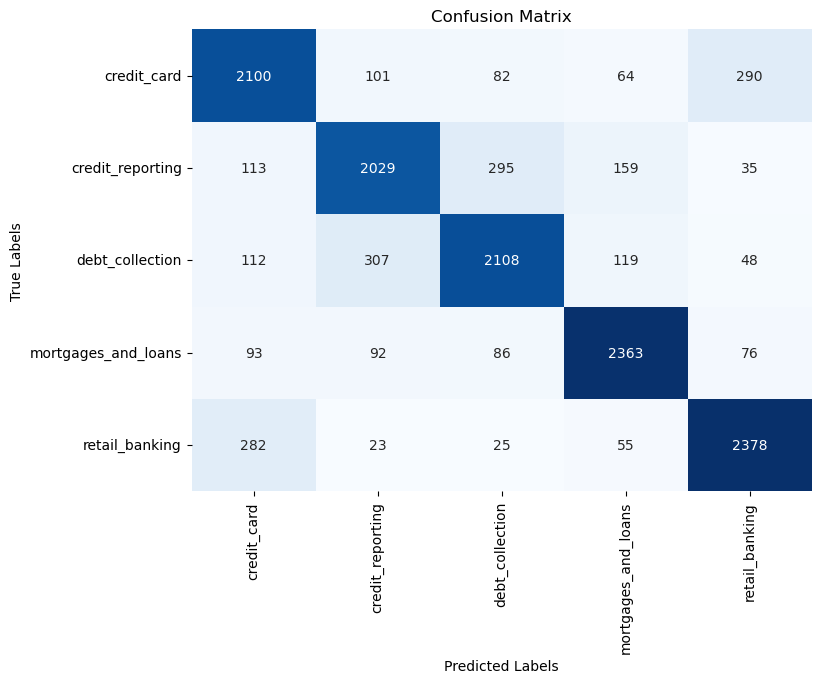

In [26]:
print("Logistic Regression Report with Word2Vec Features:")
print(report)
plot_confusion_matrix(cm)

#### 7) Word2Vec - Random Forest classifier

In [27]:
# train rf model
rf_model_w2v = RandomForestClassifier(n_estimators=100, random_state=10, n_jobs=-1)

rf_report_w2v, _ = train_evaluate_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, rf_model_w2v)
print("Random Forest Report with Word2Vec Features:")
print(rf_report_w2v)

Random Forest Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.77      0.77      0.77      2637
   credit_reporting       0.80      0.82      0.81      2631
    debt_collection       0.83      0.78      0.81      2694
mortgages_and_loans       0.84      0.85      0.84      2710
     retail_banking       0.83      0.86      0.85      2763

           accuracy                           0.82     13435
          macro avg       0.82      0.82      0.82     13435
       weighted avg       0.82      0.82      0.82     13435



##### 7.1) Word2Vec - Random Forest - Hyperparameter tuning

In [28]:
# tune rf model
param_grid_rf = {
    'n_estimators': [200, 300],
    'max_depth': [20, 30],
    'min_samples_split': [2, 5],
    'n_jobs': [-1]
}

report, cm, model = tune_and_evaluate_model(RandomForestClassifier(warm_start=True, n_jobs=WORKERS), # warm start and parallel for faster training
                                            param_grid_rf, X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)
joblib.dump(model, os.path.join("models", "rf_w2v_model.pkl"))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=20, min_samples_split=2, n_estimators=200, n_jobs=-1; total time= 2.0min


/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=20, min_samples_split=2, n_estimators=200, n_jobs=-1; total time= 2.0min
[CV] END max_depth=20, min_samples_split=2, n_estimators=200, n_jobs=-1; total time= 2.0min
[CV] END max_depth=20, min_samples_split=2, n_estimators=200, n_jobs=-1; total time= 2.0min
[CV] END max_depth=20, min_samples_split=2, n_estimators=200, n_jobs=-1; total time= 2.0min
[CV] END max_depth=20, min_samples_split=2, n_estimators=300, n_jobs=-1; total time= 2.9min
[CV] END max_depth=20, min_samples_split=2, n_estimators=300, n_jobs=-1; total time= 2.9min
[CV] END max_depth=20, min_samples_split=2, n_estimators=300, n_jobs=-1; total time= 2.9min
[CV] END max_depth=20, min_samples_split=2, n_estimators=300, n_jobs=-1; total time= 2.9min
[CV] END max_depth=20, min_samples_split=2, n_estimators=300, n_jobs=-1; total time= 2.9min
[CV] END max_depth=20, min_samples_split=5, n_estimators=200, n_jobs=-1; total time= 1.8min
[CV] END max_depth=20, min_samples_split=5, n_estimators=200, n_jobs=-1; total t

/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:468: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


['models/rf_w2v_model.pkl']

Random Forest Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.77      0.76      0.77      2637
   credit_reporting       0.81      0.82      0.82      2631
    debt_collection       0.82      0.79      0.81      2694
mortgages_and_loans       0.85      0.85      0.85      2710
     retail_banking       0.83      0.86      0.85      2763

           accuracy                           0.82     13435
          macro avg       0.82      0.82      0.82     13435
       weighted avg       0.82      0.82      0.82     13435



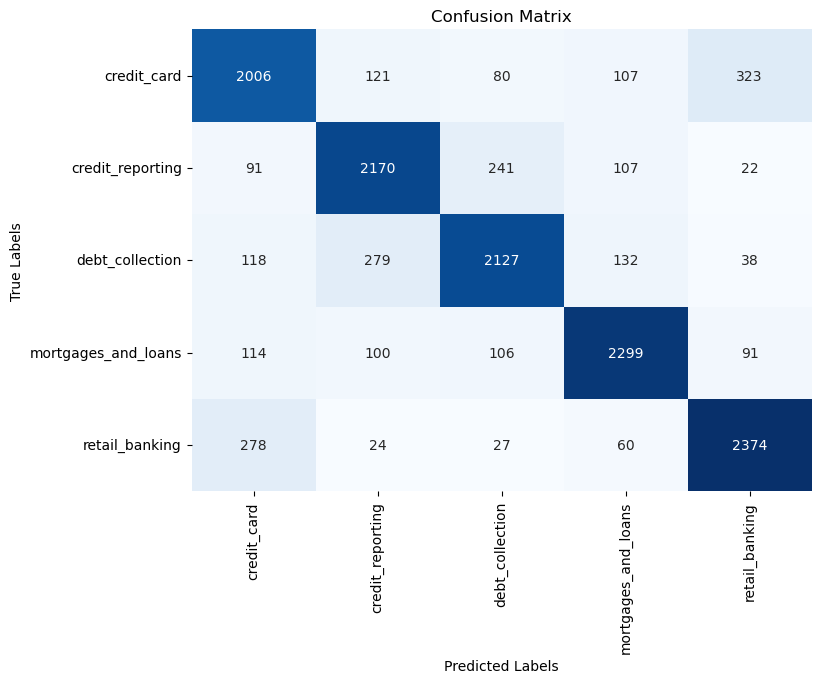

In [29]:
print("Random Forest Report with Word2Vec Features:")
print(report)
plot_confusion_matrix(cm)

#### 8) Word2Vec - XGBoost Classifier

In [30]:
# train xgb model
xgb_model_w2v = XGBClassifier(eval_metric='mlogloss')
xgb_report_w2v, _ = train_evaluate_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, xgb_model_w2v)
print("XGBoost Report with Word2Vec Features:")
print(xgb_report_w2v)

XGBoost Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.79      0.80      0.79      2637
   credit_reporting       0.82      0.82      0.82      2631
    debt_collection       0.82      0.81      0.82      2694
mortgages_and_loans       0.87      0.86      0.86      2710
     retail_banking       0.85      0.86      0.86      2763

           accuracy                           0.83     13435
          macro avg       0.83      0.83      0.83     13435
       weighted avg       0.83      0.83      0.83     13435



##### 8.1) Word2Vec - XGBoost - Hyperparameter tuning

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[CV] END ......................max_depth=3, n_estimators=100; total time=  10.2s
[CV] END ......................max_depth=3, n_estimators=100; total time=  10.3s
[CV] END ......................max_depth=3, n_estimators=100; total time=  10.4s
[CV] END ......................max_depth=3, n_estimators=100; total time=  10.5s
[CV] END ......................max_depth=3, n_estimators=100; total time=  10.5s
[CV] END ......................max_depth=3, n_estimators=200; total time=  19.0s
[CV] END ......................max_depth=3, n_estimators=200; total time=  18.9s
[CV] END ......................max_depth=3, n_estimators=200; total time=  18.9s
[CV] END ......................max_depth=3, n_estimators=200; total time=  19.3s
[CV] END ......................max_depth=3, n_estimators=200; total time=  19.2s
[CV] END ......................max_depth=4, n_estimators=100; total time=  14.0s
[CV] END ......................max_depth=4, n_estimators=100; total time=  14.3s
[CV] END ...................

/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ......................max_depth=4, n_estimators=300; total time=  40.3s
[CV] END ......................max_depth=4, n_estimators=300; total time=  40.4s
[CV] END ......................max_depth=4, n_estimators=300; total time=  40.2s
[CV] END ......................max_depth=5, n_estimators=200; total time=  34.9s
[CV] END ......................max_depth=5, n_estimators=200; total time=  36.6s
[CV] END ......................max_depth=5, n_estimators=200; total time=  36.6s
[CV] END ......................max_depth=5, n_estimators=200; total time=  37.1s
[CV] END ......................max_depth=5, n_estimators=200; total time=  36.8s
[CV] END ......................max_depth=5, n_estimators=300; total time=  50.5s
[CV] END ......................max_depth=5, n_estimators=300; total time=  50.4s
[CV] END ......................max_depth=5, n_estimators=300; total time=  50.7s
[CV] END ......................max_depth=5, n_estimators=300; total time=  50.4s
[CV] END ...................

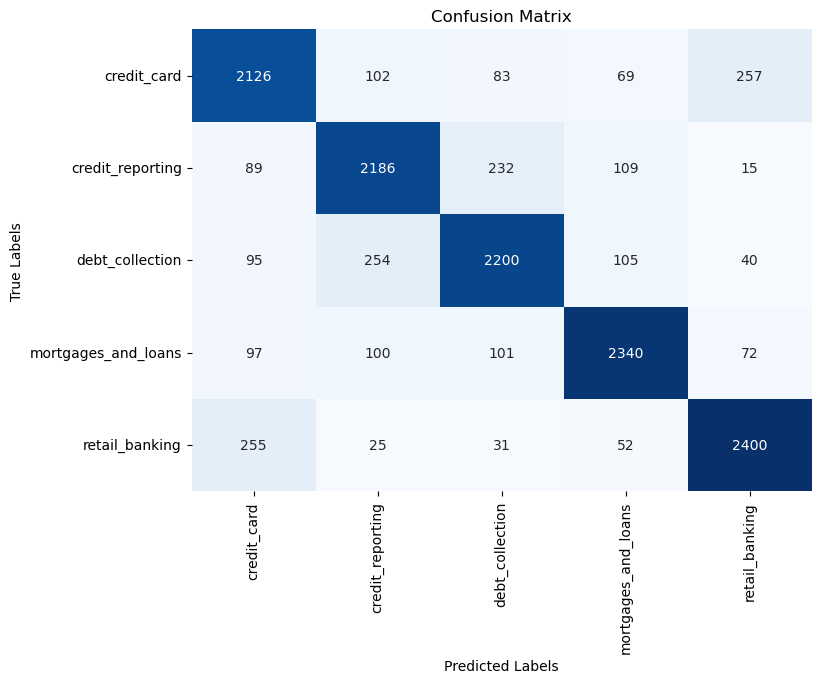

In [31]:
# XGBoost Hyperparameter tuning
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}

report, cm, model = tune_and_evaluate_model(xgb_model_w2v, param_grid_xgb, X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)
joblib.dump(model, os.path.join("models", "xgb_w2v_model.pkl"))

print("XGBoost Report with Word2Vec Features:")
print(report)
plot_confusion_matrix(cm)

#### 9) Word2Vec - Naive Bayes Classifier

In [32]:
### MultinomialNB cannot handle negative values
### switch to GaussianNB
### alternatively, we could scale the data, but not sure if that is a good idea

nb_model_w2v = GaussianNB()
nb_report_w2v, _ = train_evaluate_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, nb_model_w2v)
print("Naive Bayes Report with Word2Vec Features:")
print(nb_report_w2v)

Naive Bayes Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.65      0.59      0.62      2637
   credit_reporting       0.69      0.72      0.71      2631
    debt_collection       0.73      0.58      0.65      2694
mortgages_and_loans       0.71      0.84      0.77      2710
     retail_banking       0.76      0.81      0.78      2763

           accuracy                           0.71     13435
          macro avg       0.71      0.71      0.70     13435
       weighted avg       0.71      0.71      0.70     13435



##### 9.1) Word2Vec - Naive Bayes - Hyperparameter tuning

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-07; total time=   0.1s
[CV] END ................................var_smoo

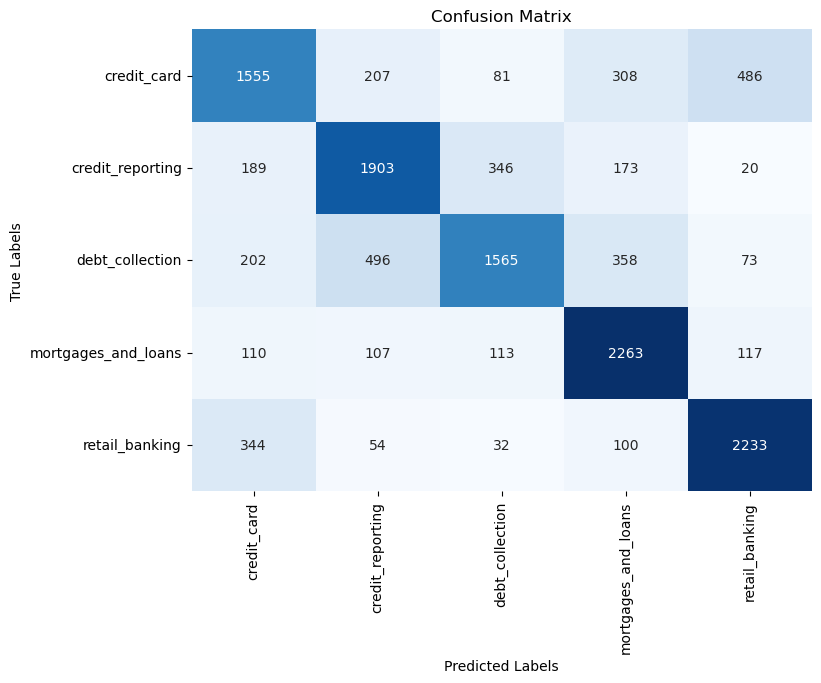

In [33]:
# Naiva Bayes Hyperparameter tuning
param_grid_nb = {
    'var_smoothing': [1e-09, 1e-08, 1e-07]
}

report, cm, model = tune_and_evaluate_model(nb_model_w2v, param_grid_nb, X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)
joblib.dump(model, os.path.join("models", "nb_w2v_model.pkl"))

print("Naive Bayes Report with Word2Vec Features:")
print(report)
plot_confusion_matrix(cm)

#### 10) Word2Vec - Support Vector Machine Classifier

In [34]:
# train a linear SVM model first with LinearSVC
svm_model_w2v = LinearSVC()
svm_report_w2v, _ = train_evaluate_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, svm_model_w2v)
print("Linear SVM Report with Word2Vec Features:")
print(svm_report_w2v)


Linear SVM Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.78      0.79      0.79      2637
   credit_reporting       0.79      0.77      0.78      2631
    debt_collection       0.81      0.77      0.79      2694
mortgages_and_loans       0.85      0.87      0.86      2710
     retail_banking       0.84      0.87      0.85      2763

           accuracy                           0.81     13435
          macro avg       0.81      0.81      0.81     13435
       weighted avg       0.81      0.81      0.81     13435



##### 10.1) Word2Vec - SVM - Hyperparameter tuning

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..............................................C=0.1; total time=  14.4s
[CV] END ..............................................C=0.1; total time=  14.8s
[CV] END ..............................................C=0.1; total time=  14.8s
[CV] END ..............................................C=0.1; total time=  15.0s


/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ..............................................C=0.1; total time=  15.1s
[CV] END ................................................C=1; total time=  16.3s
[CV] END ................................................C=1; total time=  16.5s
[CV] END ................................................C=1; total time=  16.9s
[CV] END ................................................C=1; total time=  16.9s
[CV] END ................................................C=1; total time=  17.2s
[CV] END ...............................................C=10; total time=  16.1s
[CV] END ...............................................C=10; total time=  16.0s
[CV] END ...............................................C=10; total time=  16.7s
[CV] END ...............................................C=10; total time=  16.6s
[CV] END ...............................................C=10; total time=  15.5s
[CV] END ...............................................C=15; total time=  15.9s
[CV] END ...................

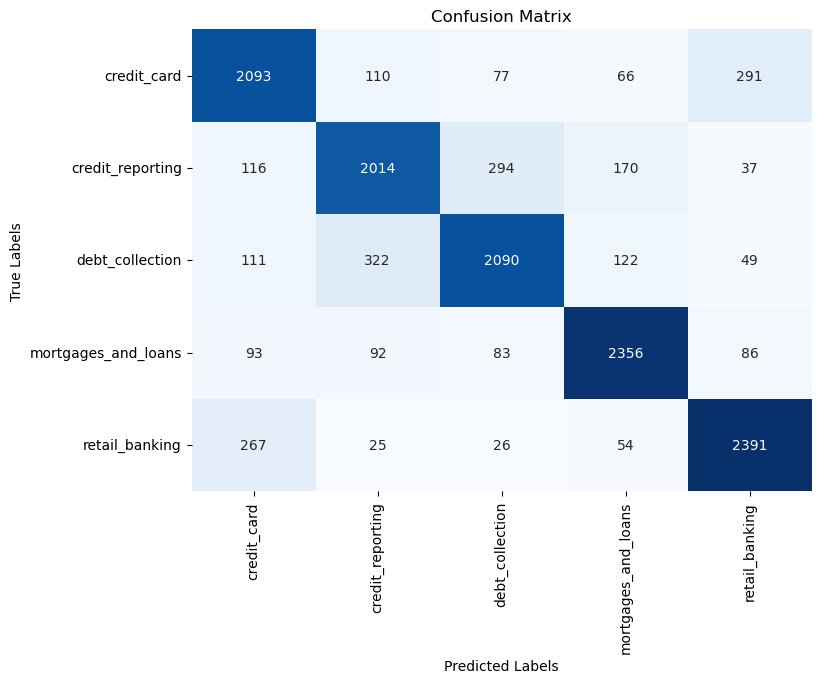

In [35]:
# tune the linear model 
param_grid_svm = {
    'C': [0.1, 1, 10, 15]
}

report, cm, model = tune_and_evaluate_model(svm_model_w2v, param_grid_svm, X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)
joblib.dump(model, os.path.join("models", "svm_lin_w2v_model.pkl"))

print("Linear SVM Report with Word2Vec Features:")
print(report)
plot_confusion_matrix(cm)

SVM Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.80      0.82      0.81      2637
   credit_reporting       0.81      0.82      0.82      2631
    debt_collection       0.84      0.82      0.83      2694
mortgages_and_loans       0.88      0.87      0.87      2710
     retail_banking       0.87      0.87      0.87      2763

           accuracy                           0.84     13435
          macro avg       0.84      0.84      0.84     13435
       weighted avg       0.84      0.84      0.84     13435



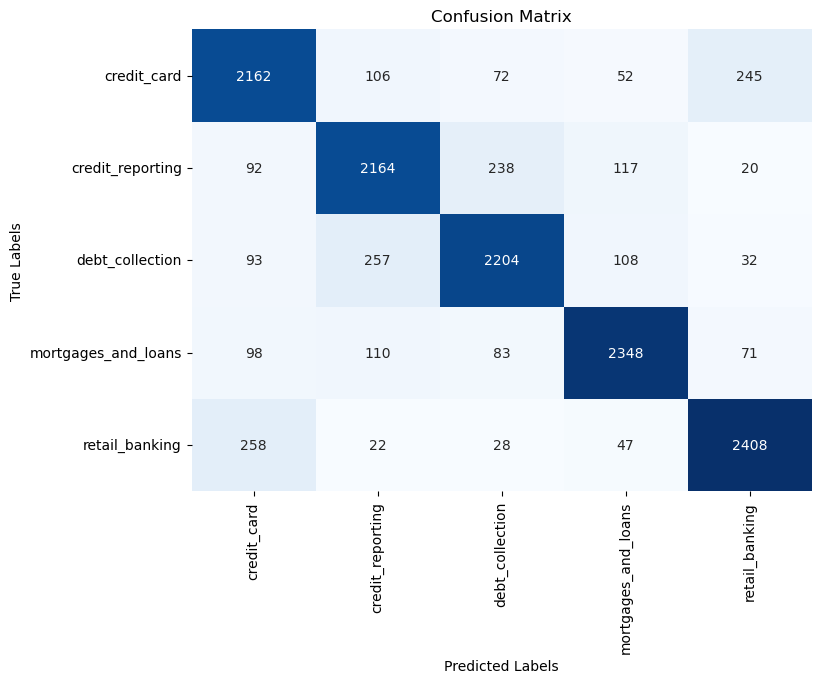

['models/svm_rbf_w2v_model.pkl']

In [36]:
# train one non-linear SVM model with rbf kernel and C=0.1 without early stopping
svm_model_w2v = SVC(kernel='rbf', C=1, cache_size=4096)
report, cm = train_evaluate_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, svm_model_w2v)

print("SVM Report with Word2Vec Features:")
print(report)
plot_confusion_matrix(cm)

# save the model
joblib.dump(svm_model_w2v, os.path.join("models", "svm_rbf_w2v_model.pkl"))

### Neural Networks

In [171]:
## use gpu if available
# use cuda if available or use mps on mac or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [172]:
# class definitions

In [173]:
## neural network

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # input layer
        self.fc2 = nn.Linear(128, 64)           # hidden layer
        self.fc3 = nn.Linear(64, num_classes)   # output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def fit(self, train_loader, epochs=10, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            self.train()  # set model to training mode
            for inputs, labels in train_loader:
                # move inputs and labels to device
                inputs, labels = inputs.to(device), labels.to(device)

                # set gradients to zero
                optimizer.zero_grad()
                # forward pass
                outputs = self(inputs)
                # calculate loss
                loss = criterion(outputs, labels)
                # backward pass
                loss.backward()
                # update weights
                optimizer.step()

            # print loss after every epoch
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss.item()}")

    def evaluate(self, X, y, target_names=None):
        self.eval()  # set to evaluation mode
        with torch.no_grad():  # disable gradient computation
            y_pred = self(X.to(device))  # move inputs to device and get predictions
            _, predicted = torch.max(y_pred, 1) # get the class with highest probability
            
            # move back to cpu for evaluation
            predicted = predicted.cpu().numpy()
            y = y.cpu().numpy()  

            print("Accuracy:", accuracy_score(y, predicted))
            print(classification_report(y, predicted, target_names=target_names))
            plot_confusion_matrix(confusion_matrix(y, predicted), target_names)

    def save(self, path):
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()

In [174]:
## convolutional neural network
# (inital idea was for all classes to inherit from NeuralNetwork, but it was a bit too much for this task and hard to debug
# so they were kept separate and just have their own evaluate, save, load method)

class Convolution(NeuralNetwork):
    def __init__(self, input_size, num_classes):
        super(Convolution, self).__init__(input_size, num_classes)  

        # 2 1d convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        
        # max-pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # calculate the flattened size for the fully connected layer
        self.flattened_size = self._get_flattened_size(input_size)
        
        # fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)  # number of classes

    def _get_flattened_size(self, input_size):
        # create a dummy input to calculate the size after convolutions and pooling
        x = torch.randn(1, 1, input_size)  # shape (batch_size, channels, sequence_length)
        x = self.pool(torch.relu(self.conv1(x))) # pass through first convolution and pooling
        x = self.pool(torch.relu(self.conv2(x))) # pass through second convolution and pooling
        flattened_size = x.view(1, -1).size(1) # flatten the tensor
        return flattened_size

    def forward(self, x):
        # pass through first convolution and pooling
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
    
        # pass through second convolution and pooling
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
    
        # flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)  # flatten
    
        # fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # output logits (no activation here, softmax/crossentropy later)
        return x
    
    def evaluate(self, data_loader, target_names=None):
        self.eval()  # set the model to evaluation mode
        all_preds = []  
        all_labels = []  

        with torch.no_grad():  # disable gradient computation
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # move to device
                y_pred = self(inputs)  # forward pass to get predictions
                _, predicted = torch.max(y_pred, 1)  # get predicted class with highest probability

                # store predictions and labels
                all_preds.append(predicted.cpu().numpy())  # move predictions to cpu and convert to numpy
                all_labels.append(labels.cpu().numpy())    # move labels to cpu and convert to numpy

        # concatenate all predictions and labels
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        # evaluate and print metrics
        print("Accuracy:", accuracy_score(all_labels, all_preds))
        print(classification_report(all_labels, all_preds, target_names=target_names))
        plot_confusion_matrix(confusion_matrix(all_labels, all_preds), target_names)


In [175]:
## recurrent neural network
class Recurrent(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Recurrent, self).__init__()
        # rnn layer
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        # fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # pass through rnn
        out, _ = self.rnn(x)  # shape: (batch_size, seq_length, hidden_size)
        # get the last output
        out = out[:, -1, :]    # shape: (batch_size, hidden_size)
        # pass through fully connected layer
        out = self.fc(out)     # shape: (batch_size, num_classes)
        return out
    
    def fit(self, train_loader, epochs=10, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            self.train()
            for inputs, labels in train_loader:
                # move inputs and labels to device
                inputs, labels = inputs.to(device), labels.to(device)
                # set gradients to zero
                optimizer.zero_grad()
                # forward pass to get predictions
                outputs = self(inputs)
                # calculate loss
                loss = criterion(outputs, labels)
                # backward pass
                loss.backward()
                # update weights
                optimizer.step()
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss.item()}")


    def evaluate(self, data_loader, target_names=None):
        self.eval()  # set the model to evaluation mode
        all_preds = []  # to store predictions
        all_labels = []  # to store true labels

        with torch.no_grad():  # disable gradient computation
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # move to device
                y_pred = self(inputs)  # forward pass
                _, predicted = torch.max(y_pred, 1)  # get predicted class

                # store predictions and labels
                all_preds.append(predicted.cpu().numpy())  # move predictions to cpu and convert to numpy
                all_labels.append(labels.cpu().numpy())    # move labels to cpu and convert to numpy

        # concatenate all predictions and labels
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        # evaluate and print metrics
        print("Accuracy:", accuracy_score(all_labels, all_preds))
        print(classification_report(all_labels, all_preds, target_names=target_names))
        plot_confusion_matrix(confusion_matrix(all_labels, all_preds), target_names)

    def save(self, path):
            torch.save(self.state_dict(), path)

    def load(self, path):
            self.load_state_dict(torch.load(path))
            self.eval()



In [215]:
## bidirectional lstm

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiLSTM, self).__init__()
        # bi-directional LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=2, 
                            batch_first=True, bidirectional=True)
        
        # fully connected layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # multiply hidden_size by 2 for bidirectional

    def forward(self, x):
        # pass through LSTM
        out, _ = self.lstm(x)  # Shape: (batch_size, seq_length, hidden_size * 2)
        # get the last output
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
        # pass through fully connected layer
        out = self.fc(out)  # Shape: (batch_size, num_classes)
        return out

    def fit(self, train_loader, epochs=10, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            self.train()
            for inputs, labels in train_loader:
                # move inputs and labels to device
                inputs, labels = inputs.to(device), labels.to(device)
                # set gradients to zero
                optimizer.zero_grad()
                # forward pass to get predictions
                outputs = self(inputs)
                # calculate loss
                loss = criterion(outputs, labels)
                # backward pass
                loss.backward()
                # update weights
                optimizer.step()
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss.item()}")

    def evaluate(self, data_loader, target_names=None):
        self.eval()  # set the model to evaluation mode
        all_preds = []  
        all_labels = []  

        with torch.no_grad():  # disable gradient computation
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # move to device
                # forward pass to get predictions
                y_pred = self(inputs) 
                # get the class with highest probability
                _, predicted = torch.max(y_pred, 1)  # Get predicted class

                # store predictions and labels
                all_preds.append(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy
                all_labels.append(labels.cpu().numpy())    # Move labels to CPU and convert to numpy

        # concatenate all predictions and labels
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        # evaluate and print metrics
        print("Accuracy:", accuracy_score(all_labels, all_preds))
        print(classification_report(all_labels, all_preds, target_names=target_names))
        plot_confusion_matrix(confusion_matrix(all_labels, all_preds), target_names)
    
    def save(self, path):
        torch.save(self.state_dict(), path)
    

    def load(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()

    



#### Multilayer NN

##### TFIDF

In [183]:
# prepare tensors of TF-IDF embeddings and move to device
X_train_tensor = torch.tensor(X_train.values).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_test_tensor = torch.tensor(X_test.values).float().to(device)
y_test_tensor = torch.tensor(y_test).long().to(device)

# create a data loader
batch_size = 128 
train_dataset_tfidf = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=batch_size, shuffle=True)

# train the model
num_classes = len(np.unique(y_train))  
model_nn = NeuralNetwork(input_size=X_train_tensor.shape[1], num_classes=num_classes).to(device)
model_nn.fit(train_loader_tfidf, epochs=10, lr=0.001)


Epoch 1/10 - Loss: 0.6825339794158936
Epoch 2/10 - Loss: 0.4981456696987152
Epoch 3/10 - Loss: 0.6351438164710999
Epoch 4/10 - Loss: 0.49117496609687805
Epoch 5/10 - Loss: 0.44691234827041626
Epoch 6/10 - Loss: 0.4234073758125305
Epoch 7/10 - Loss: 0.5332198739051819
Epoch 8/10 - Loss: 0.636106550693512
Epoch 9/10 - Loss: 0.5384211540222168
Epoch 10/10 - Loss: 0.42335784435272217


Neural Network Report with TFIDF Features:
Accuracy: 0.8182359508745813
                     precision    recall  f1-score   support

        credit_card       0.82      0.76      0.79      2637
   credit_reporting       0.78      0.80      0.79      2631
    debt_collection       0.81      0.79      0.80      2694
mortgages_and_loans       0.85      0.85      0.85      2710
     retail_banking       0.83      0.88      0.86      2763

           accuracy                           0.82     13435
          macro avg       0.82      0.82      0.82     13435
       weighted avg       0.82      0.82      0.82     13435



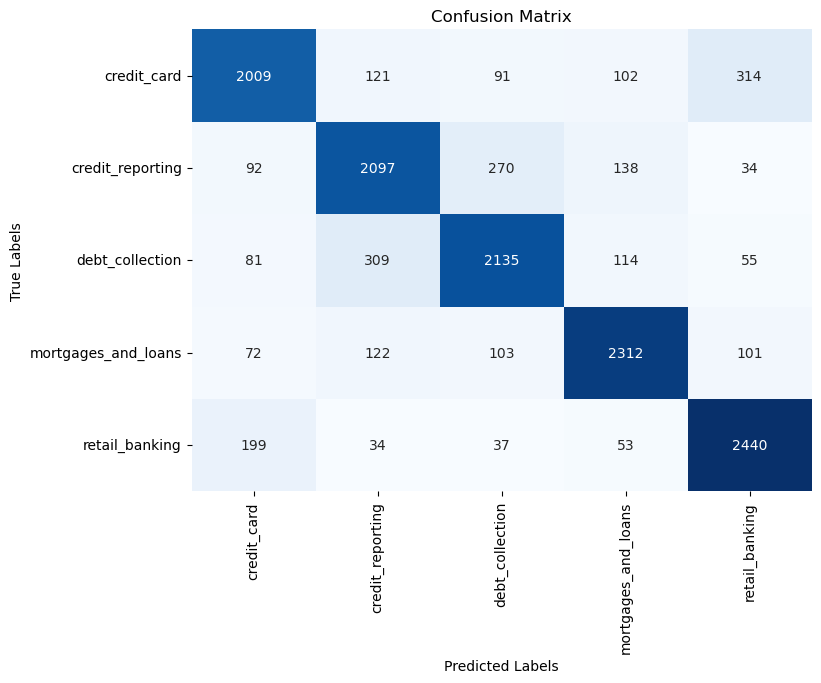

In [180]:
# Evaluate the model
print("Neural Network Report with TFIDF Features:")
model_nn.evaluate(X_test_tensor, y_test_tensor, target_names=le.classes_)  

##### Word2Vec

In [182]:
# prepare tensors of word2vec embeddings and move to device
X_train_tensor_w2v = torch.tensor(X_train_w2v.values).float().to(device)
y_train_tensor_w2v = torch.tensor(y_train_w2v).long().to(device)
X_test_tensor_w2v = torch.tensor(X_test_w2v.values).float().to(device)
y_test_tensor_w2v = torch.tensor(y_test_w2v).long().to(device)

# create a data loader
train_dataset_w2v = TensorDataset(X_train_tensor_w2v, y_train_tensor_w2v)
train_loader_w2v = DataLoader(train_dataset_w2v, batch_size=batch_size, shuffle=True)

# train the model
model_nn_w2v = NeuralNetwork(input_size=X_train_tensor_w2v.shape[1], num_classes=num_classes).to(device)
model_nn_w2v.fit(train_loader_w2v, epochs=10, lr=0.001)

Epoch 1/10 - Loss: 0.5197727084159851
Epoch 2/10 - Loss: 0.43025505542755127
Epoch 3/10 - Loss: 0.4382312595844269
Epoch 4/10 - Loss: 0.5367829203605652
Epoch 5/10 - Loss: 0.4827041029930115
Epoch 6/10 - Loss: 0.3810026943683624
Epoch 7/10 - Loss: 0.3516446650028229
Epoch 8/10 - Loss: 0.4879104495048523
Epoch 9/10 - Loss: 0.41446223855018616
Epoch 10/10 - Loss: 0.4537689685821533


Neural Network Report with Word2Vec Features:
Accuracy: 0.8393003349460365
                     precision    recall  f1-score   support

        credit_card       0.84      0.78      0.81      2637
   credit_reporting       0.84      0.78      0.81      2631
    debt_collection       0.79      0.85      0.82      2694
mortgages_and_loans       0.86      0.88      0.87      2710
     retail_banking       0.86      0.89      0.88      2763

           accuracy                           0.84     13435
          macro avg       0.84      0.84      0.84     13435
       weighted avg       0.84      0.84      0.84     13435



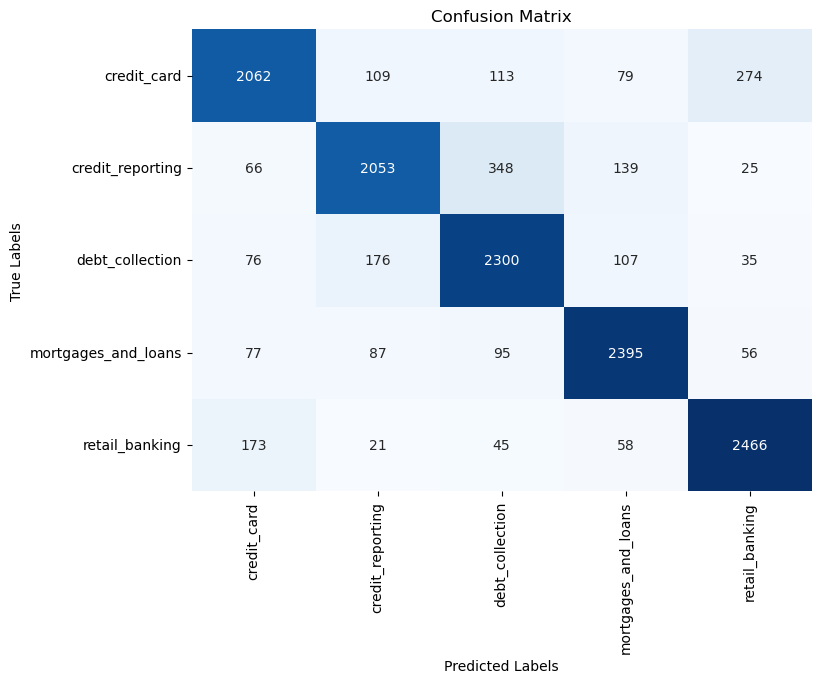

In [186]:
# evaluate the model
print("Neural Network Report with Word2Vec Features:")
model_nn_w2v.evaluate(X_test_tensor_w2v, y_test_tensor_w2v, target_names=le.classes_)
# Save the model
model_nn_w2v.save(os.path.join("models", "nn_w2v_model.pth"))

#### Convolutional Neural Network

##### TFIDF

In [198]:
# prepare tensors of TF-IDF embeddings and move to device
X_train_tensor = torch.tensor(X_train.values).float().unsqueeze(1).to(device)  # Shape: (batch_size, 1, seq_length)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)  # Shape: (batch_size, 1, seq_length)
y_test_tensor = torch.tensor(y_test).long().to(device)

# create a data loader
batch_size = 64
train_dataset_cnn_tfidf = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_cnn_tfidf = DataLoader(train_dataset_cnn_tfidf, batch_size=batch_size, shuffle=True, drop_last=True)

# create data loader for testing
test_dataset_cnn_tfidf = TensorDataset(X_test_tensor, y_test_tensor)
test_loader_cnn_tfidf = DataLoader(test_dataset_cnn_tfidf, batch_size=batch_size, shuffle=False, drop_last=True)


In [199]:
# initialize the model
model_cnn = Convolution(input_size=X_train_tensor.shape[2], num_classes=num_classes).to(device)
model_cnn.fit(train_loader_cnn_tfidf, epochs=10, lr=0.001)


Epoch 1/10 - Loss: 0.4294026494026184
Epoch 2/10 - Loss: 0.5169712901115417
Epoch 3/10 - Loss: 0.5689328908920288
Epoch 4/10 - Loss: 0.6191505193710327
Epoch 5/10 - Loss: 0.6030243039131165
Epoch 6/10 - Loss: 0.4787750840187073
Epoch 7/10 - Loss: 0.5593866109848022
Epoch 8/10 - Loss: 0.377460241317749
Epoch 9/10 - Loss: 0.2852492034435272
Epoch 10/10 - Loss: 0.1966942548751831


Convolutional Neural Network Report with TFIDF Features:
Accuracy: 0.8130233253588517
                     precision    recall  f1-score   support

        credit_card       0.79      0.78      0.79      2623
   credit_reporting       0.77      0.81      0.79      2624
    debt_collection       0.78      0.80      0.79      2681
mortgages_and_loans       0.87      0.82      0.85      2697
     retail_banking       0.85      0.85      0.85      2751

           accuracy                           0.81     13376
          macro avg       0.81      0.81      0.81     13376
       weighted avg       0.81      0.81      0.81     13376



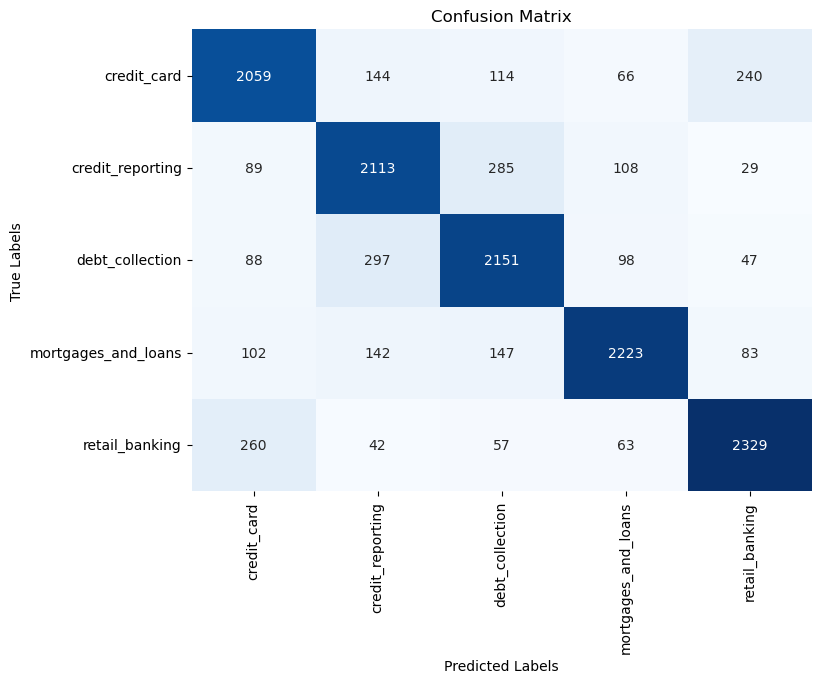

In [200]:
print("Convolutional Neural Network Report with TFIDF Features:")
model_cnn.evaluate(test_loader_cnn_tfidf, target_names=le.classes_)

In [201]:
# save the model
model_cnn.save(os.path.join("models", "cnn_tfidf_model.pth"))


##### Word2Vec

In [202]:
# prepare tensors of word2vec embeddings and move to device
X_train_tensor_w2v = torch.tensor(X_train_w2v.values).float().unsqueeze(1).to(device)  # Shape: (batch_size, 1, seq_length)
y_train_tensor_w2v = torch.tensor(y_train_w2v).long().to(device)
X_test_tensor_w2v = torch.tensor(X_test_w2v.values).float().unsqueeze(1).to(device)  # Shape: (batch_size, 1, seq_length)
y_test_tensor_w2v = torch.tensor(y_test_w2v).long().to(device)

# create a data loader
train_dataset_cnn_w2v = TensorDataset(X_train_tensor_w2v, y_train_tensor_w2v)
train_loader_cnn_w2v = DataLoader(train_dataset_cnn_w2v, batch_size=batch_size, shuffle=True, drop_last=True)

# dataloader for testing
test_dataset_cnn_w2v = TensorDataset(X_test_tensor_w2v, y_test_tensor_w2v)
test_loader_cnn_w2v = DataLoader(test_dataset_cnn_w2v, batch_size=batch_size, shuffle=False, drop_last=True)


In [203]:
# Initialize the model with the correct number of classes
cnn_model_w2v = Convolution(input_size=X_train_tensor_w2v.shape[2], num_classes=num_classes).to(device)
# Train the model
cnn_model_w2v.fit(train_loader_cnn_w2v, epochs=10, lr=0.001)

Epoch 1/10 - Loss: 0.5947310924530029
Epoch 2/10 - Loss: 0.3415523171424866
Epoch 3/10 - Loss: 0.4114786982536316
Epoch 4/10 - Loss: 0.5375317335128784
Epoch 5/10 - Loss: 0.3470313549041748
Epoch 6/10 - Loss: 0.3581607937812805
Epoch 7/10 - Loss: 0.24956128001213074
Epoch 8/10 - Loss: 0.36722332239151
Epoch 9/10 - Loss: 0.29343828558921814
Epoch 10/10 - Loss: 0.3097662329673767


Convolutional Neural Network Report with Word2Vec Features:
Accuracy: 0.8316387559808612
                     precision    recall  f1-score   support

        credit_card       0.78      0.81      0.80      2623
   credit_reporting       0.84      0.79      0.82      2624
    debt_collection       0.81      0.83      0.82      2681
mortgages_and_loans       0.86      0.87      0.86      2697
     retail_banking       0.86      0.86      0.86      2751

           accuracy                           0.83     13376
          macro avg       0.83      0.83      0.83     13376
       weighted avg       0.83      0.83      0.83     13376



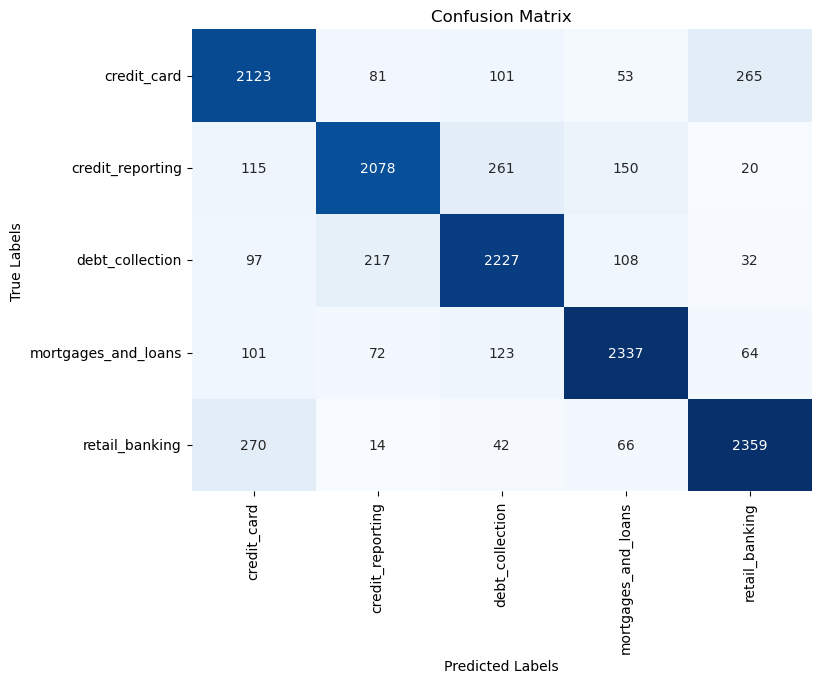

In [204]:
# evaluate the model
print("Convolutional Neural Network Report with Word2Vec Features:")
cnn_model_w2v.evaluate(test_loader_cnn_w2v, target_names=le.classes_)
# save the model
cnn_model_w2v.save(os.path.join("models", "cnn_w2v_model.pth"))

#### Recurrent NN

##### TFIDF

In [207]:
# initialize and train the model
num_classes = len(torch.unique(y_train_tensor))  # Or however you determine the number of classes
rnn_model = Recurrent(input_size=X_train_tensor.shape[2], hidden_size=128, num_classes=num_classes).to(device)
rnn_model.fit(train_loader_cnn_tfidf, epochs=10, lr=0.001)


Epoch 1/10 - Loss: 0.6954343318939209
Epoch 2/10 - Loss: 0.4257725775241852
Epoch 3/10 - Loss: 0.4786607027053833
Epoch 4/10 - Loss: 0.5808812975883484
Epoch 5/10 - Loss: 0.7022172212600708
Epoch 6/10 - Loss: 0.5894099473953247
Epoch 7/10 - Loss: 0.8058451414108276
Epoch 8/10 - Loss: 0.6790986061096191
Epoch 9/10 - Loss: 0.5897481441497803
Epoch 10/10 - Loss: 0.8267489075660706


Recurrent Neural Network Report with TFIDF Features:
Accuracy: 0.793136961722488
                     precision    recall  f1-score   support

        credit_card       0.79      0.74      0.76      2623
   credit_reporting       0.76      0.74      0.75      2624
    debt_collection       0.75      0.78      0.77      2681
mortgages_and_loans       0.83      0.85      0.84      2697
     retail_banking       0.83      0.86      0.84      2751

           accuracy                           0.79     13376
          macro avg       0.79      0.79      0.79     13376
       weighted avg       0.79      0.79      0.79     13376



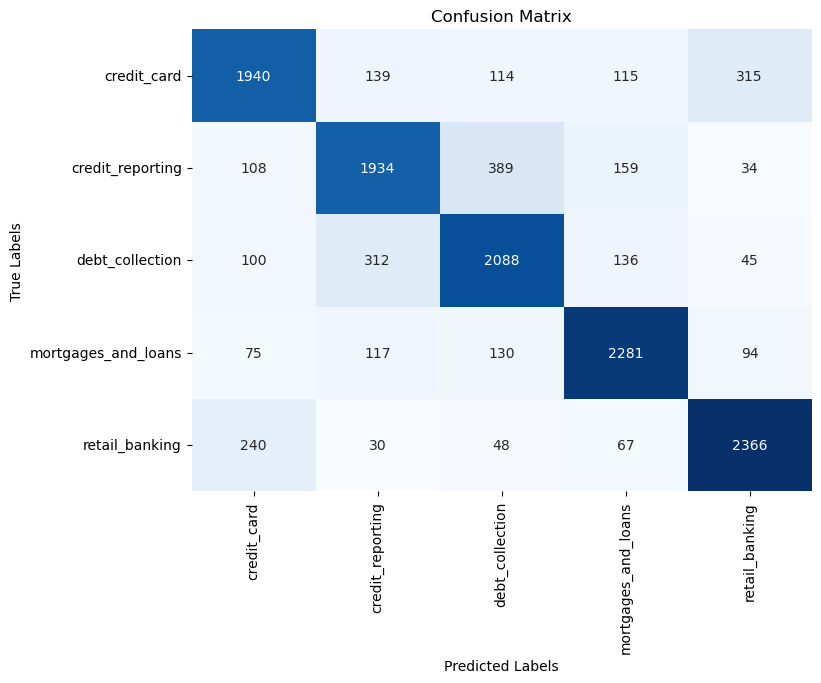

In [206]:
# evaluate the model
print("Recurrent Neural Network Report with TFIDF Features:")
rnn_model.evaluate(test_loader_cnn_tfidf, target_names=le.classes_)
# save the model
rnn_model.save(os.path.join("models", "rnn_tfidf_model.pth"))

##### Word2Vec

In [208]:
# train model
rnn_model = Recurrent(input_size=X_train_tensor_w2v.shape[2], hidden_size=128, num_classes=num_classes).to(device)
rnn_model.fit(train_loader_cnn_w2v, epochs=10, lr=0.001)

Epoch 1/10 - Loss: 0.6668518781661987
Epoch 2/10 - Loss: 0.4116540551185608
Epoch 3/10 - Loss: 0.5788635015487671
Epoch 4/10 - Loss: 0.39061224460601807
Epoch 5/10 - Loss: 0.3960312604904175
Epoch 6/10 - Loss: 0.5565706491470337
Epoch 7/10 - Loss: 0.3443599045276642
Epoch 8/10 - Loss: 0.4647083580493927
Epoch 9/10 - Loss: 0.4285857677459717
Epoch 10/10 - Loss: 0.3698921501636505


Recurrent Neural Network Report with Word2Vec Features:
Accuracy: 0.8305921052631579
                     precision    recall  f1-score   support

        credit_card       0.80      0.80      0.80      2623
   credit_reporting       0.83      0.78      0.81      2624
    debt_collection       0.78      0.86      0.82      2681
mortgages_and_loans       0.88      0.85      0.87      2697
     retail_banking       0.87      0.86      0.86      2751

           accuracy                           0.83     13376
          macro avg       0.83      0.83      0.83     13376
       weighted avg       0.83      0.83      0.83     13376



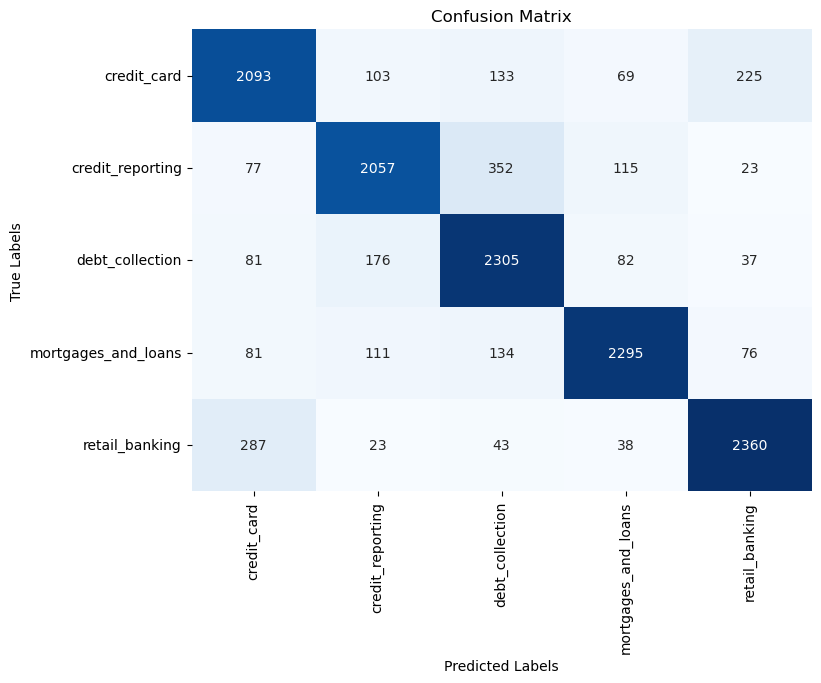

In [209]:
# evaluate model
print("Recurrent Neural Network Report with Word2Vec Features:")
rnn_model.evaluate(test_loader_cnn_w2v, target_names=le.classes_)
# save model
rnn_model.save(os.path.join("models", "rnn_w2v_model.pth"))

#### Bi-LSTM

##### TFIDF

In [217]:
# initialize and train the model
bilstm_model = BiLSTM(input_size=X_train_tensor.shape[2], hidden_size=128, num_classes=num_classes).to(device)
bilstm_model.fit(train_loader_cnn_tfidf, epochs=10, lr=0.001)

Epoch 1/10 - Loss: 0.6499898433685303
Epoch 2/10 - Loss: 0.5574716329574585
Epoch 3/10 - Loss: 0.45649784803390503
Epoch 4/10 - Loss: 0.4781993627548218
Epoch 5/10 - Loss: 0.5208688378334045
Epoch 6/10 - Loss: 0.5957716703414917
Epoch 7/10 - Loss: 0.5050692558288574
Epoch 8/10 - Loss: 0.4254107177257538
Epoch 9/10 - Loss: 0.5829188227653503
Epoch 10/10 - Loss: 0.42803800106048584


Bidirectional LSTM Report with TFIDF Features:
Accuracy: 0.8184808612440191
                     precision    recall  f1-score   support

        credit_card       0.80      0.79      0.80      2623
   credit_reporting       0.79      0.77      0.78      2624
    debt_collection       0.81      0.79      0.80      2681
mortgages_and_loans       0.85      0.86      0.86      2697
     retail_banking       0.84      0.87      0.85      2751

           accuracy                           0.82     13376
          macro avg       0.82      0.82      0.82     13376
       weighted avg       0.82      0.82      0.82     13376



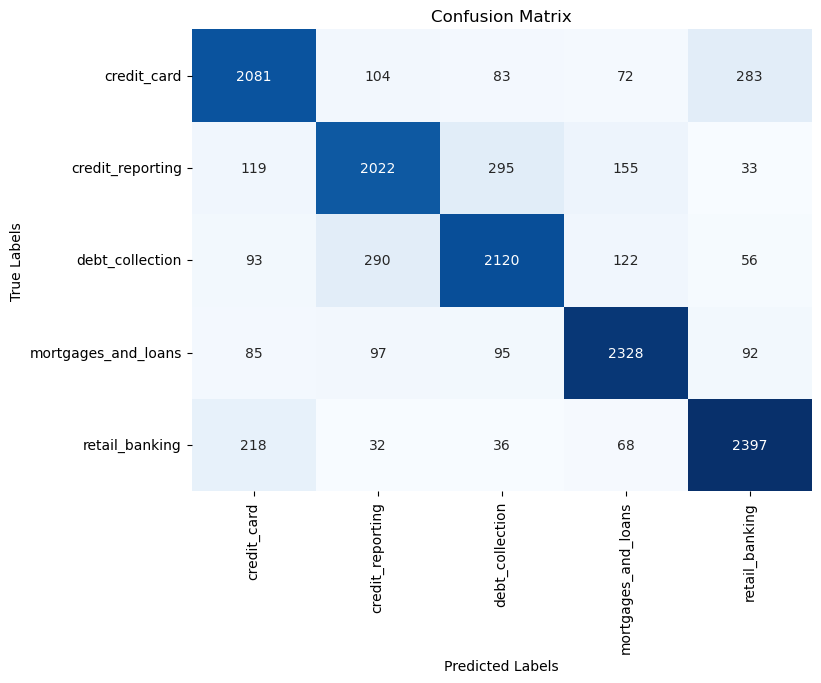

In [218]:
# evaluate the model
print("Bidirectional LSTM Report with TFIDF Features:")
bilstm_model.evaluate(test_loader_cnn_tfidf, target_names=le.classes_)
# save the model
bilstm_model.save(os.path.join("models", "bilstm_tfidf_model.pth"))

##### Word2Vec

In [219]:
# initialize and train the model
bilstm_model_w2v = BiLSTM(input_size=X_train_tensor_w2v.shape[2], hidden_size=128, num_classes=num_classes).to(device)
bilstm_model_w2v.fit(train_loader_cnn_w2v, epochs=10, lr=0.001)


Epoch 1/10 - Loss: 0.5005694627761841
Epoch 2/10 - Loss: 0.3704507350921631
Epoch 3/10 - Loss: 0.5707126259803772
Epoch 4/10 - Loss: 0.565617561340332
Epoch 5/10 - Loss: 0.318916916847229
Epoch 6/10 - Loss: 0.5462801456451416
Epoch 7/10 - Loss: 0.39301496744155884
Epoch 8/10 - Loss: 0.4221320152282715
Epoch 9/10 - Loss: 0.23100179433822632
Epoch 10/10 - Loss: 0.3126671016216278


Bidirectional LSTM Report with Word2Vec Features:
Accuracy: 0.8383672248803827
                     precision    recall  f1-score   support

        credit_card       0.80      0.83      0.81      2623
   credit_reporting       0.80      0.84      0.82      2624
    debt_collection       0.83      0.81      0.82      2681
mortgages_and_loans       0.86      0.88      0.87      2697
     retail_banking       0.90      0.84      0.87      2751

           accuracy                           0.84     13376
          macro avg       0.84      0.84      0.84     13376
       weighted avg       0.84      0.84      0.84     13376



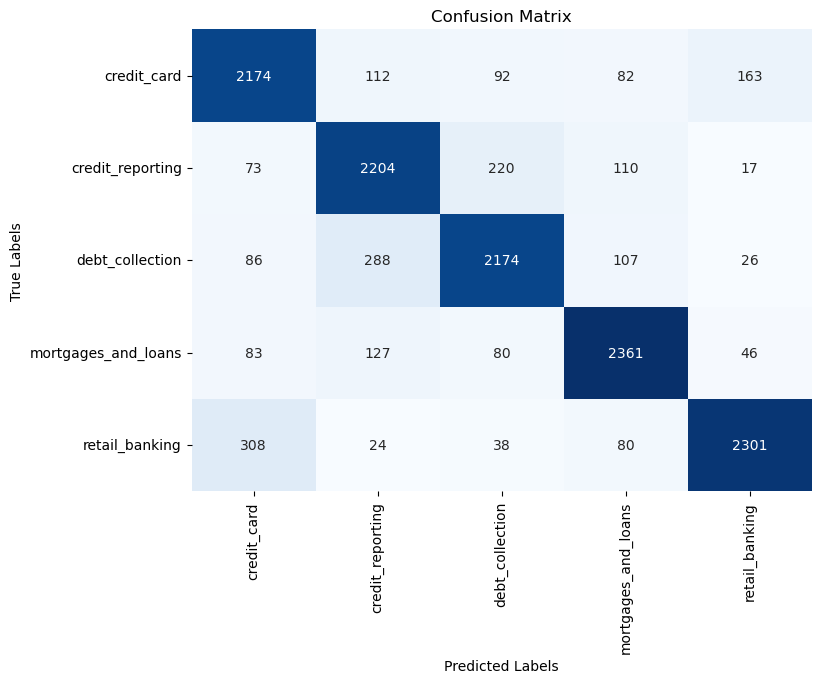

In [220]:
# evaluate the model
print("Bidirectional LSTM Report with Word2Vec Features:")
bilstm_model_w2v.evaluate(test_loader_cnn_w2v, target_names=le.classes_)
# save the model
bilstm_model_w2v.save(os.path.join("models", "bilstm_w2v_model.pth"))
